In [21]:
import os

import pandas as pd
import numpy as np
from decimal import Decimal
from IPython.display import Image
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20,.2f}'.format

from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

export_flag = True
if export_flag:
    import chart_studio
    chart_studio.tools.set_credentials_file(username='madhuripagale', api_key='VjAkDULWOLtjYAGgGuBD')

In [6]:
DataSet = pd.read_csv('/content/Supply_Chain_Shipment_Pricing_Data.csv').fillna(0)

In [7]:
len(DataSet)

10324

In [8]:
DataSet.dtypes

id                                int64
project code                     object
pq #                             object
po / so #                        object
asn/dn #                         object
country                          object
managed by                       object
fulfill via                      object
vendor inco term                 object
shipment mode                    object
pq first sent to client date     object
po sent to vendor date           object
scheduled delivery date          object
delivered to client date         object
delivery recorded date           object
product group                    object
sub classification               object
vendor                           object
item description                 object
molecule/test type               object
brand                            object
dosage                           object
dosage form                      object
unit of measure (per pack)        int64
line item quantity                int64


In [9]:
DataSet.rename(columns={'freight cost (usd)':'Freight'}, inplace=True)

In [10]:
print('After:', DataSet.columns)

After: Index(['id', 'project code', 'pq #', 'po / so #', 'asn/dn #', 'country',
       'managed by', 'fulfill via', 'vendor inco term', 'shipment mode',
       'pq first sent to client date', 'po sent to vendor date',
       'scheduled delivery date', 'delivered to client date',
       'delivery recorded date', 'product group', 'sub classification',
       'vendor', 'item description', 'molecule/test type', 'brand', 'dosage',
       'dosage form', 'unit of measure (per pack)', 'line item quantity',
       'line item value', 'pack price', 'unit price', 'manufacturing site',
       'first line designation', 'weight (kilograms)', 'Freight',
       'line item insurance (usd)'],
      dtype='object')


In [11]:
print(DataSet.isnull().sum())

id                              0
project code                    0
pq #                            0
po / so #                       0
asn/dn #                        0
country                         0
managed by                      0
fulfill via                     0
vendor inco term                0
shipment mode                   0
pq first sent to client date    0
po sent to vendor date          0
scheduled delivery date         0
delivered to client date        0
delivery recorded date          0
product group                   0
sub classification              0
vendor                          0
item description                0
molecule/test type              0
brand                           0
dosage                          0
dosage form                     0
unit of measure (per pack)      0
line item quantity              0
line item value                 0
pack price                      0
unit price                      0
manufacturing site              0
first line des

In [12]:
DataSet['Freight'].unique()

array(['780.34', '4521.5', '1653.78', ..., '26180', '3410',
       'See DN-4282 (ID#:83919)'], dtype=object)

In [13]:
regex = {
    "id_number": ":\d*"
}

def change_to_number(Freight):
    match = re.search(regex['id_number'], Freight, re.IGNORECASE)
    if match:
        id = match.group(0).replace(':','')
        filtered = DataSet.query("id == "+id)
        return filtered['Freight'].item()
    else:
        return Freight
def convert_to_number(weight):
    match = re.search(regex['id_number'], weight, re.IGNORECASE)
    if match:
        id = match.group(0).replace(':','')
        filtered = DataSet.query("id == "+id)
        return filtered['weight (kilograms)'].item()
    else:
        return weight

In [14]:
DataSet['Freight_Cost_USD_Clean'] = DataSet['Freight'].apply(change_to_number)
DataSet['Weight_Kilograms_Clean'] = DataSet['weight (kilograms)'].apply(convert_to_number)

In [15]:
DataSet['shipment mode'].unique()

array(['Air', 0, 'Truck', 'Air Charter', 'Ocean'], dtype=object)

In [16]:
freight_cost_indexes = DataSet.index[(DataSet['Freight_Cost_USD_Clean'] == 'Freight Included in Commodity Cost') 
                        | (DataSet['Freight_Cost_USD_Clean'] == 'Invoiced Separately')].tolist()
weight_indexes = DataSet.index[DataSet['Weight_Kilograms_Clean'] == 'Weight Captured Separately'].tolist()
shipment_indexes = DataSet.index[DataSet['shipment mode'] == 0].tolist()
print("Freight_Cost_USD_Clean indexes:",len(freight_cost_indexes))
print("Weight_Kilograms_Clean indexes:",len(weight_indexes))
print("Shipment Mode indexes:         ",len(shipment_indexes))

indexes = list(set(freight_cost_indexes + weight_indexes + shipment_indexes))
print("Indexes:",len(indexes))
DataSetClean = DataSet.drop(indexes)

print("Size:", DataSetClean.shape)

DataSetClean[['unit of measure (per pack)', 'line item quantity', 'pack price', 'unit price', 'weight (kilograms)',
                          'country', 'shipment mode', 'Freight']]

Freight_Cost_USD_Clean indexes: 1786
Weight_Kilograms_Clean indexes: 1633
Shipment Mode indexes:          360
Indexes: 2142
Size: (8182, 35)


,unit of measure (per pack),line item quantity,pack price,unit price,weight (kilograms),country,shipment mode,Freight
0,30,19,29.00,0.97,13,Côte d'Ivoire,Air,780.34
1,240,1000,6.20,0.03,358,Vietnam,Air,4521.5
2,100,500,80.00,0.80,171,Côte d'Ivoire,Air,1653.78
3,60,31920,3.99,0.07,1855,Vietnam,Air,16007.06
4,60,38000,3.20,0.05,7590,Vietnam,Air,45450.08
...,...,...,...,...,...,...,...,...
10316,60,15000,6.52,0.11,1547,Nigeria,Air Charter,3410
10317,30,6724,3.12,0.10,See DN-4282 (ID#:83919),Nigeria,Air,See DN-4282 (ID#:83919)
10318,60,205243,3.60,0.06,See DN-4307 (ID#:83920),Zimbabwe,Truck,See DN-4307 (ID#:83920)
10319,60,166571,3.60,0.06,See DN-4307 (ID#:83920),Zimbabwe,Truck,See DN-4307 (ID#:83920)


In [17]:
shipment_mode = DataSetClean['shipment mode'].unique()
print('shipment mode', shipment_mode, '\n')

countries = DataSetClean['country'].unique()
print('countries', countries, '\n')

manufacturing = DataSetClean['manufacturing site'].unique()
print('manufacturing', manufacturing)

shipment mode ['Air' 'Truck' 'Air Charter' 'Ocean'] 

countries ["Côte d'Ivoire" 'Vietnam' 'Nigeria' 'Tanzania' 'Zambia' 'Rwanda' 'Haiti'
 'Ethiopia' 'Guyana' 'Zimbabwe' 'Namibia' 'Botswana' 'Mozambique' 'Kenya'
 'Uganda' 'Senegal' 'Benin' 'Lesotho' 'Swaziland' 'Angola' 'Pakistan'
 'Sierra Leone' 'Cameroon' 'South Sudan' 'Burundi' 'South Africa' 'Malawi'
 'Congo, DRC' 'Sudan' 'Dominican Republic' 'Mali' 'Ghana' 'Togo'
 'Afghanistan' 'Guatemala' 'Liberia' 'Guinea' 'Libya'] 

manufacturing ['Ranbaxy Fine Chemicals LTD' 'Aurobindo Unit III, India'
 'ABBVIE GmbH & Co.KG Wiesbaden' 'Ranbaxy, Paonta Shahib, India'
 'Trinity Biotech, Plc' 'Cipla, Goa, India' 'Premier Med. Corp Ltd. India'
 'BMS Meymac, France' 'Chembio Diagnostics Sys. Inc.'
 'ABBVIE Ludwigshafen Germany' 'Inverness Japan'
 'Pacific Biotech, Thailand' 'Standard Diagnostics, Korea'
 'Gilead(Nycomed) Oranienburg DE' 'Bio-Rad Laboratories'
 'Mylan (formerly Matrix) Nashik' 'Novartis Pharma AG, Switzerland'
 'Not Applicable' 'Ipc

In [18]:
DataSetClean['country_encoded'] = DataSetClean['country'].map( {
    'South Africa': 1, 
    'Nigeria': 2,
    "Côte d'Ivoire": 3, 
    'Uganda': 4,
    'Vietnam': 5,
    'Zambia': 6, 
    'Haiti': 7, 
    'Mozambique': 8,
    'Zimbabwe': 9,
    'Tanzania': 10, 
    'Rwanda': 11, 
    'Congo, DRC': 12, 
    'Guyana': 13, 
    'Ethiopia': 14,
    'South Sudan': 15,
    'Kenya': 16, 
    'Burundi': 17, 
    'Namibia': 18, 
    'Cameroon': 19, 
    'Botswana': 20, 
    'Ghana': 21, 
    'Dominican Republic': 22, 
    'Sudan': 23, 
    'Swaziland': 24,
    'Mali': 25, 
    'Pakistan': 26,
    'Guatemala': 27,
    'Malawi': 28, 
    'Benin': 29, 
    'Lebanon': 30, 
    'Libya': 31, 
    'Angola': 32, 
    'Liberia': 33,
    'Lesotho': 34,
    'Sierra Leone': 35,
    'Togo': 36, 
    'Afghanistan': 37,
    'Senegal': 38, 
    'Kyrgyzstan': 39,
    'Burkina Faso': 40,
    'Kazakhstan': 41,
    'Guinea': 42,
    'Belize': 43 } ).astype(int)
DataSetClean['shipment_mode_encoded'] = DataSetClean['shipment mode'].map({ 
    'Air': 1,
    'Truck': 2,
    'Air Charter': 3,
    'Ocean': 4 } ).astype(int)

DataSetClean['manufacturing_site_encoded'] = DataSetClean['manufacturing site'].map({ 
    'Ranbaxy Fine Chemicals LTD': 1,
    'Aurobindo Unit III, India': 2,
    'ABBVIE GmbH & Co.KG Wiesbaden': 3,
    'Ranbaxy, Paonta Shahib, India': 4,
    'Trinity Biotech, Plc': 5,
    'Cipla, Goa, India': 6,
    'Premier Med. Corp Ltd. India': 7,
    'BMS Meymac, France': 8,
    'Chembio Diagnostics Sys. Inc.': 9,
    'ABBVIE Ludwigshafen Germany': 10,
    'Inverness Japan': 11,
    'Pacific Biotech, Thailand': 12,
    'Standard Diagnostics, Korea': 13,
    'Gilead(Nycomed) Oranienburg DE': 14,
    'Bio-Rad Laboratories': 15,
    'Mylan (formerly Matrix) Nashik': 16,
    'Novartis Pharma AG, Switzerland': 17,
    'Not Applicable': 18,
    'Ipca Dadra/Nagar Haveli IN': 19,
    'MSD, Haarlem, NL': 20,
    'Gland Pharma Ltd Pally Factory': 21,
    'ABBVIE (Abbott) Logis. UK': 22,
    'Hetero Unit III Hyderabad IN': 23,
    'ABBVIE (Abbott) France': 24,
    'Strides, Bangalore, India.': 25,
    'Cipla, Patalganga, India': 26,
    'Aspen-OSD, Port Elizabeth, SA': 27,
    'KHB Test Kit Facility, Shanghai China': 28,
    'Inverness USA': 29,
    "MSD Midrand, J'burg, SA": 30,
    'OMEGA Diagnostics, UK': 31,
    'Roche Madrid': 32,
    'INVERNESS ORGENICS LINE': 33,
    'GSK Aranda': 34,
    'Novartis Pharma Suffern, USA': 35,
    'Roche Basel': 36,
    "ABBVIE (Abbott) St. P'burg USA": 37,
    'GSK Mississauga (Canada)': 38,
    'Micro Labs Ltd. (Brown & Burk), India': 39,
    'Meditab (for Cipla) Daman IN': 40,
    'Medopharm Malur Factory, INDIA': 41,
    'Orasure Technologies, Inc USA': 42,
    'Weifa A.S., Hausmanngt. 6, P.O. Box 9113 GrÃ¸nland, 0133, Oslo, Norway': 43,
    'GSK Cape Town Factory (South Africa)': 44,
    'MSD Manati, Puerto Rico, (USA)': 45,
    'MSD Elkton USA': 46,
    'GSK Ware (UK)': 47,
    'MSD Patheon, Canada': 48,
    'GSK Crawley': 49,
    'Emcure Plot No.P-2, I.T-B.T. Park, Phase II, MIDC, Hinjwadi, Pune, India': 50,
    'MSD South Granville Australia': 51,
    'Alere Medical Co., Ltd.': 52,
    'Premier Medical Corporation': 53,
    'Janssen-Cilag, Latina, IT': 54,
    'Aurobindo Unit VII, IN': 55,
    'Micro labs, Verna, Goa, India': 56,
    'Orasure Technologies, Inc': 57,
    'Mylan,  H-12 & H-13, India': 58,
    'Hetero, Jadcherla, unit 5, IN': 59,
    'Bristol-Myers Squibb Anagni IT': 60,
    'Medochemie Factory A, CY': 61,
    'Cipla Ltd A-42 MIDC Mahar. IN': 62,
    'bioLytical Laboratories': 63,
    'EY Laboratories, USA': 64,
    'Micro Labs, Hosur, India': 65,
    'Remedica, Limassol, Cyprus': 66,
    'INVERNESS ANY': 67,
    'Guilin OSD site, No 17, China': 68,
    'Cipla, Kurkumbh, India': 69,
    'GSK Barnard Castle UK': 70,
    'Janssen Ortho LLC, Puerto Rico': 71,
    'Gland Pharma, Hyderabad, IN': 72,
    'Access BIO, L.C.': 73,
    'Human Diagnostic': 74,
    'BMS Evansville, US': 75,
    'Mepro Pharm Wadhwan Unit II': 76,
    'Ranbaxy per Shasun Pharma Ltd': 77,
    'Ranbaxy per Shasun Pharma': 78,
    'Macleods Daman Plant INDIA': 79
}).astype(int)

In [19]:
DataSetClean['Freight_Cost_USD_Clean'] = pd.to_numeric(DataSetClean['Freight_Cost_USD_Clean'])
DataSetClean['Weight_Kilograms_Clean'] = pd.to_numeric(DataSetClean['Weight_Kilograms_Clean'])
DataSetClean.dtypes

id                                int64
project code                     object
pq #                             object
po / so #                        object
asn/dn #                         object
country                          object
managed by                       object
fulfill via                      object
vendor inco term                 object
shipment mode                    object
pq first sent to client date     object
po sent to vendor date           object
scheduled delivery date          object
delivered to client date         object
delivery recorded date           object
product group                    object
sub classification               object
vendor                           object
item description                 object
molecule/test type               object
brand                            object
dosage                           object
dosage form                      object
unit of measure (per pack)        int64
line item quantity                int64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



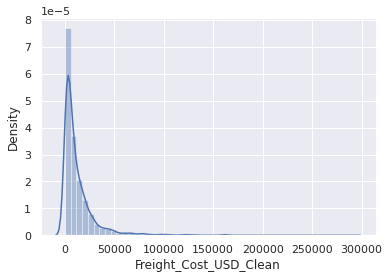

In [22]:
sns.set(style = 'darkgrid')
sns.distplot(DataSetClean['Freight_Cost_USD_Clean'])

In [23]:
predictors = DataSetClean[['unit of measure (per pack)', 'line item quantity', 'pack price', 'unit price', 'Weight_Kilograms_Clean',
                          'country_encoded', 'shipment_mode_encoded', 'manufacturing_site_encoded']]
predictors

,unit of measure (per pack),line item quantity,pack price,unit price,Weight_Kilograms_Clean,country_encoded,shipment_mode_encoded,manufacturing_site_encoded
0,30,19,29.00,0.97,13,3,1,1
1,240,1000,6.20,0.03,358,5,1,2
2,100,500,80.00,0.80,171,3,1,3
3,60,31920,3.99,0.07,1855,5,1,4
4,60,38000,3.20,0.05,7590,5,1,2
...,...,...,...,...,...,...,...,...
10316,60,15000,6.52,0.11,1547,2,3,2
10317,30,6724,3.12,0.10,6183,2,1,25
10318,60,205243,3.60,0.06,25880,9,2,6
10319,60,166571,3.60,0.06,25880,9,2,58


In [24]:
predictors.describe()

,unit of measure (per pack),line item quantity,pack price,unit price,Weight_Kilograms_Clean,country_encoded,shipment_mode_encoded,manufacturing_site_encoded
count,"8,182.00","8,182.00","8,182.00","8,182.00","8,182.00","8,182.00","8,182.00","8,182.00"
mean,75.33,"21,201.81",20.68,0.60,"4,545.52",7.52,1.48,15.84
std,76.55,"42,549.60",41.77,2.35,"13,661.93",5.41,0.79,15.85
min,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
25%,30.00,847.25,3.78,0.07,283.00,3.00,1.00,2.00
50%,60.00,"4,449.50",8.26,0.15,"1,351.50",6.00,1.00,11.00
75%,90.00,"21,505.50",20.50,0.41,"4,481.25",10.00,2.00,23.00
max,"1,000.00","619,999.00","1,250.00",30.00,"857,354.00",42.00,4.00,79.00


In [25]:
targets = DataSetClean.Freight_Cost_USD_Clean
targets

0                     780.34
1                   4,521.50
2                   1,653.78
3                  16,007.06
4                  45,450.08
                ...         
10316               3,410.00
10317              47,281.56
10318              46,111.55
10319              46,111.55
10320              14,734.92
Name: Freight_Cost_USD_Clean, Length: 8182, dtype: float64

In [26]:
train_features, test_features, train_targets, test_targets = train_test_split(predictors, targets, test_size=0.2, random_state=3)

print('test features shape: ', test_features.shape)
print('test targets shape: ', test_targets.shape)

print('train features shape: ', train_features.shape)
print('train targets shape: ', train_targets.shape)

test features shape:  (1637, 8)
test targets shape:  (1637,)
train features shape:  (6545, 8)
train targets shape:  (6545,)


In [27]:
tree_regressor = DecisionTreeRegressor(max_depth=15) # MAE 6.08 minutes, R2 -1.20

tree_regressor = tree_regressor.fit(train_features, train_targets)

print('node_count => ', tree_regressor.tree_.node_count)

tree_regressor.get_params()

node_count =>  4331


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [28]:

tree_predictions = tree_regressor.predict(test_features)
df = pd.DataFrame({'Actual':test_targets, 'Predicted':tree_predictions})  
df

,Actual,Predicted
10026,"3,526.27","3,418.37"
5424,"62,466.03","59,711.34"
2860,"1,131.48","2,857.46"
7063,"6,036.96","7,643.47"
1750,"7,534.18","7,199.72"
...,...,...
9356,"8,329.13","11,814.57"
1401,"7,329.83","3,410.00"
317,"20,635.30","15,120.97"
3439,"8,858.67","5,186.07"


In [29]:
from sklearn import metrics

In [30]:
results = pd.DataFrame({'Score':['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error', 'R Square']})
tree_score = [metrics.mean_absolute_error(test_targets, tree_predictions),
             np.sqrt(metrics.mean_squared_error(test_targets, tree_predictions)),
             metrics.mean_squared_error(test_targets, tree_predictions)/10000,
             metrics.r2_score(test_targets, tree_predictions)*10000]
results['Tree Desicion'] = tree_score

print('Mean Absolute Error:     {} [$]'.format(results.iloc[0, 1]))    
print('Root Mean Squared Error: {} [$]'.format(results.iloc[1, 1]))
print('Mean Squared Error:      {} [$]'.format(results.iloc[2, 1]))
print('R Square:                {} [%]'.format(results.iloc[3, 1])) # 1 is better
results

Mean Absolute Error:     4978.522240371381 [$]
Root Mean Squared Error: 11161.427415520626 [$]
Mean Squared Error:      12457.746195193542 [$]
R Square:                5856.372623335555 [%]


,Score,Tree Desicion
0,Mean Absolute Error,"4,978.52"
1,Root Mean Squared Error,"11,161.43"
2,Mean Squared Error,"12,457.75"
3,R Square,"5,856.37"


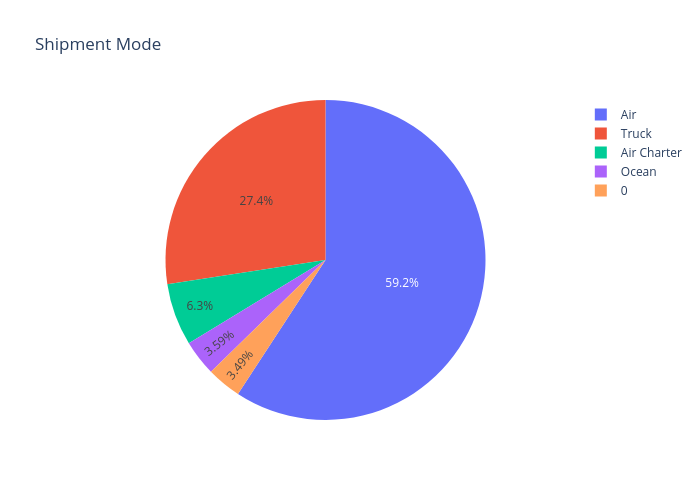

In [32]:
ShippingMode = DataSet["shipment mode"].value_counts()
labels = (np.array(ShippingMode.index))
sizes = (np.array((ShippingMode / ShippingMode.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title="Shipment Mode")
dat = [trace]
fig = go.Figure(data=dat, layout=layout)

show_image = None
if export_flag:    
    chart_studio.plotly.image.save_as(fig, filename='shipment-mode-plot.png')
    show_image = Image('shipment-mode-plot.png')
else:
    py.iplot(fig, filename="Shipment Mode")
    
show_image